<a href="https://colab.research.google.com/github/viyas52/stock-market-prediction-using-twitter-sentiment-analysis/blob/main/twitter_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install emoji

In [15]:
import pandas as pd
from preprocess import Preprocess_Tweets

csv_file = "12.3-18.3.csv"
data = pd.read_csv(csv_file)


if 'createdAt' not in data.columns:
    raise ValueError("The dataset does not contain a 'created_at' column.")

# Preprocess the tweets
data = Preprocess_Tweets(data)


data['createdAt'] = pd.to_datetime(data['createdAt'])


output_file = "cleaned_twitter_data.csv"
data.to_csv(output_file, index=False)

print(f"Preprocessed data saved to {output_file}")

Preprocessed data saved to cleaned_twitter_data.csv


/usr/local/lib/python3.11/dist-packages/pandas/core/strings/object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)
<ipython-input-15-054cd381096f>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['createdAt'] = pd.to_datetime(data['createdAt'])


In [16]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()

        input_layer = 768
        hidden_layer = 50
        output_layer = 2

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, output_layer)
        )

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        h_cls = outputs[0][:, 0, :]
        logits = self.classifier(h_cls)
        return logits

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.load_state_dict(torch.load("stock_sentiment_model.pt", map_location=device))
model.to(device)
model.eval()


df = pd.read_csv("cleaned_twitter_data.csv")
# Fix starts here
df = df.dropna(subset=['Text_Cleaned'])
df['Text_Cleaned'] = df['Text_Cleaned'].astype(str)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 64

def tokenize_tweets(texts):
    tokens = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=MAX_LEN,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )
    return tokens['input_ids'], tokens['attention_mask']

input_ids, attention_masks = tokenize_tweets(df['Text_Cleaned'])

# Convert to PyTorch tensors and move to device
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)


with torch.no_grad():
    logits = model(input_ids, attention_masks)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

df['Sentiment'] = preds


df[['createdAt','Text_Cleaned', 'Sentiment']].to_csv("predicted_tweets.csv", index=False)
print("Predictions saved to predicted_tweets.csv")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions saved to predicted_tweets.csv


In [17]:

df_predicted = pd.read_csv("predicted_tweets.csv")



df_predicted['createdAt'] = pd.to_datetime(df_predicted['createdAt'], errors='coerce')
df_predicted['Date'] = df_predicted['createdAt'].dt.date


df_predicted['Sentiment'] = df_predicted['Sentiment']
df_predicted.drop(columns=['createdAt'], inplace=True)

df_predicted["Date"] = pd.to_datetime(df_predicted["Date"])

aggregated_senti = df_predicted.groupby("Date")["Sentiment"].apply(lambda x: 1 if x.mean() >= 0.5 else 0).reset_index()
aggregated_senti_path = "aggregated_senti.csv"
aggregated_senti.to_csv(aggregated_senti_path, index=False)


aggregated_senti.head()


,Date,Sentiment
0,2025-03-12,1
1,2025-03-13,1
2,2025-03-14,1
3,2025-03-15,1
4,2025-03-16,1


In [18]:
import yfinance as yf
import pandas as pd


df = yf.download("AAPL", start="2024-01-01", end="2025-03-18")

df.reset_index(inplace=True)


available_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[[col for col in available_columns if col in df.columns]]

df.to_csv("apple_stock.csv", index=False)
print("Apple stock data saved successfully!")


print(df.head())

[*********************100%***********************]  1 of 1 completed

Apple stock data saved successfully!
Price        Date        Open        High         Low       Close    Volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
0      2024-01-02  186.033072  187.315382  182.792533  184.532089  82488700
1      2024-01-03  183.120571  184.770668  182.335277  183.150391  58414500
2      2024-01-04  181.062914  181.997307  179.800504  180.824356  71983600
3      2024-01-05  180.903872  181.669266  179.094727  180.098694  62303300
4      2024-01-08  181.003268  184.492330  180.416793  184.452560  59144500


In [19]:
import pandas as pd

df = pd.read_csv("apple_stock.csv")


df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")


df["Close"] = pd.to_numeric(df["Close"], errors="coerce")

df["Sentiment"] = (df["Close"].diff() > 0).astype(int)

df.to_csv("apple_stock_senti.csv", index=False)

print(df.head())


        Date                Open                High                 Low  \
1 2024-01-02  186.03307200647276  187.31538170646215  182.79253333369908   
2 2024-01-03   183.1205708792931  184.77066759112085   182.3352771284137   
3 2024-01-04  181.06291404030495  181.99730650228184  179.80050438167336   
4 2024-01-05  180.90387243418792   181.6692660827433  179.09472708075188   
5 2024-01-08   181.0032684531674  184.49233019548157  180.41679326133186   

        Close    Volume  Sentiment  
1  184.532089  82488700          0  
2  183.150391  58414500          0  
3  180.824356  71983600          0  
4  180.098694  62303300          0  
5  184.452560  59144500          1  


In [20]:
import pandas as pd

stock_df = pd.read_csv("apple_stock_senti.csv")
agg_senti_df = pd.read_csv("aggregated_senti.csv")

stock_df["Date"] = pd.to_datetime(stock_df["Date"])
agg_senti_df["Date"] = pd.to_datetime(agg_senti_df["Date"])

senti_dict = agg_senti_df.set_index("Date")["Sentiment"].to_dict()

stock_df["Sentiment"] = stock_df["Date"].map(senti_dict).fillna(stock_df["Sentiment"])

stock_df.to_csv("model.csv", index=False)

print("Sentiment values replaced successfully!")


Sentiment values replaced successfully!


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load dataset
file_path = "model.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Feature Selection: Use Open, High, Low, Volume, Sentiment to predict 'Close'
# Convert necessary columns to numeric
columns_to_convert = ["Open", "High", "Low", "Close", "Volume"]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # Convert to float, set invalid values to NaN

# Drop rows with NaN values (optional, but recommended)
df.dropna(inplace=True)


# Split data into train & test sets (80% train, 20% test)
# Define features and target
features = ["Open", "High", "Low", "Volume", "Sentiment"]
target = "Close"

# Split data into train & test sets (80% train, 20% test)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale data for LSTM model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results
results = {}

# ----------------- Linear Regression -----------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
results["Linear Regression"] = {"MSE": mse_lr, "R² Score": r2_lr}

# ----------------- Random Forest -----------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
results["Random Forest"] = {"MSE": mse_rf, "R² Score": r2_rf}

# ----------------- XGBoost -----------------
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
results["XGBoost"] = {"MSE": mse_xgb, "R² Score": r2_xgb}

# ----------------- LSTM -----------------
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mean_squared_error")

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=1)

# Predict with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
results["LSTM"] = {"MSE": mse_lstm, "R² Score": r2_lstm}

# ----------------- Print Results -----------------
print("\nModel Performance Comparison:")
for model, metrics in results.items():
    print(f"{model} - MSE: {metrics['MSE']:.4f}, R² Score: {metrics['R² Score']:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 42175.0117
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 40962.5820
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 36800.3359
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 28910.1582
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 25181.0020
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 20212.2344
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16450.7031
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12988.0225
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9954.3721
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7496.8271
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5254.8525
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3699.4841
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2490.9360
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1685.1382
Epoch 15/20
16/16 ━━━━━━━━━━━━━━

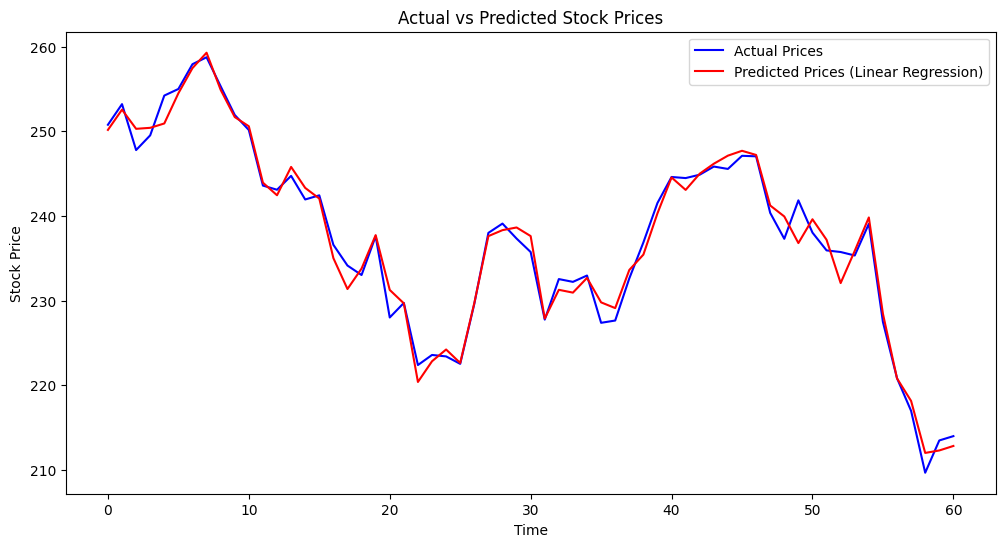

In [22]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Prices", color='blue')
plt.plot(y_pred_lr, label="Predicted Prices (Linear Regression)", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()